In [1]:
import sys
sys.path.append("/Users/johnduva/Desktop/Git/NeuroData/brainlit") 

from brainlit.utils.session import NeuroglancerSession
# from brainlit.utils.swc import graph_to_paths
import napari
import pandas as pd
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from cloudvolume import CloudVolume, view
from tifffile import imsave
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics

/Users/johnduva/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


### Get the voxel coordinates of each neuron (voxs), and look at the subvolume (imgs)

In [2]:
%%capture
dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
mip = 2; radius = 6; v_id = 0

imgs = []; voxs = [];
ngl_sess = NeuroglancerSession(mip=mip, url=dir, url_segments=dir_segments)
for seg_id in range(1000):
    try:
        vox = ngl_sess._get_voxel(seg_id, v_id) 
        voxs.append(vox)
    except:
        pass

### Pull the full volume and index to get the 1000x1000x1000 middle-most volume

In [68]:
x1 = 4100; x2 = 4304;
y1 = 3900; y2 = 4104;
z1 = 1600; z2 = 1804;
vol = CloudVolume(dir, parallel=False, mip=2, progress=True, fill_missing=True)

### Create array 'cells' of coordinates for known cells

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]


<Figure size 432x288 with 0 Axes>

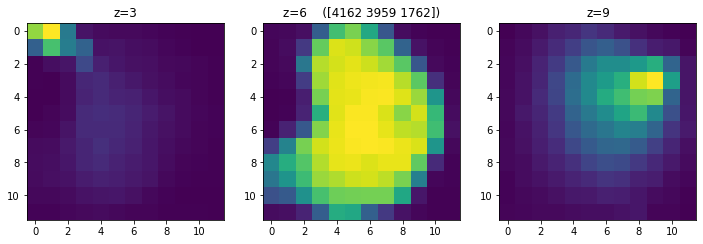

<Figure size 432x288 with 0 Axes>

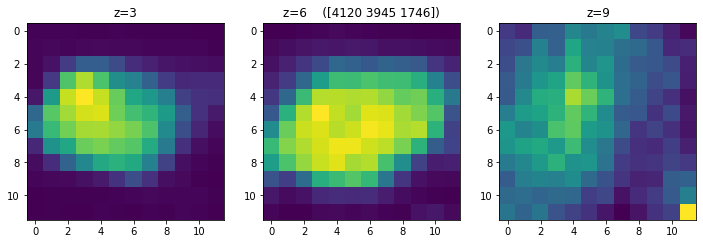

<Figure size 432x288 with 0 Axes>

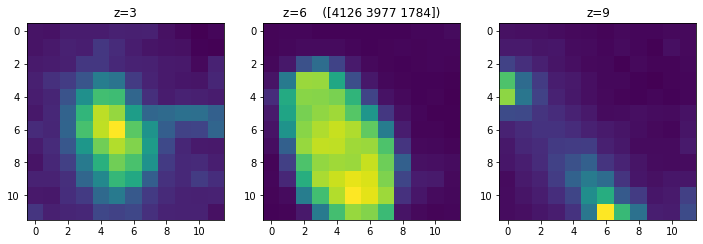

<Figure size 432x288 with 0 Axes>

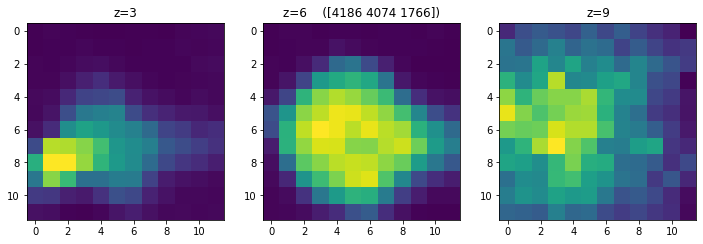

<Figure size 432x288 with 0 Axes>

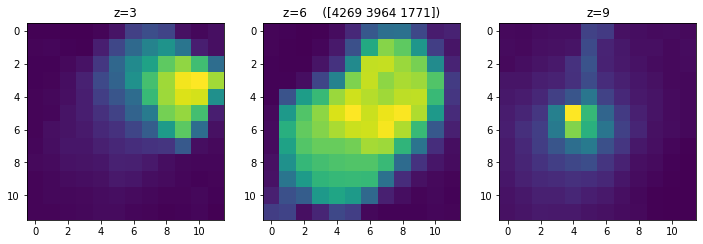

<Figure size 432x288 with 0 Axes>

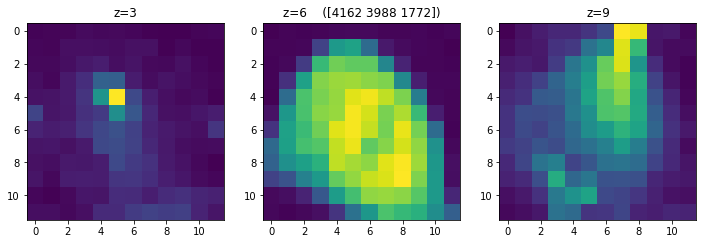

<Figure size 432x288 with 0 Axes>

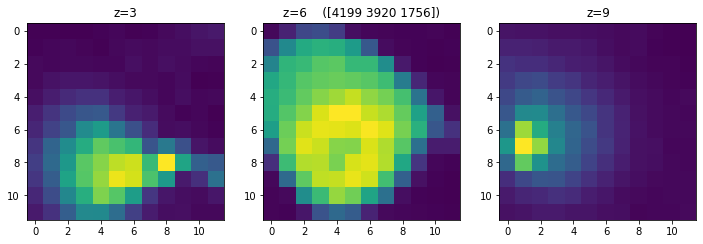

<Figure size 432x288 with 0 Axes>

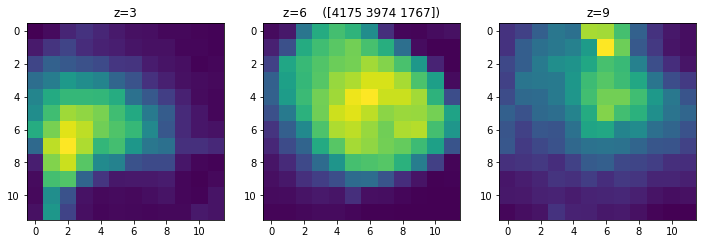

<Figure size 432x288 with 0 Axes>

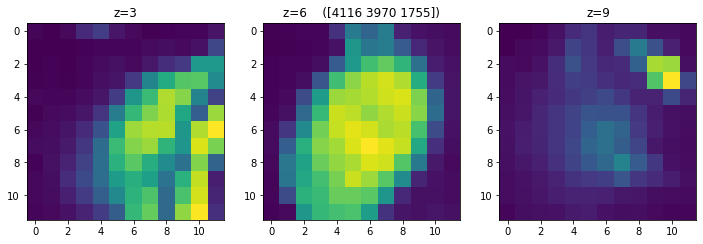

In [69]:
cells = []
for i, vox in enumerate(voxs): 
    """ If the cell is within our above-defined rectangular volume... """
    if vox[0]>=x1 and vox[0]<x2 and vox[1]>=y1 and vox[1]<y2 and vox[2]>=z1 and vox[2]<z2:        
        """ ...append it to 'cells' array """
        cells.append(vox)
        """ Show three slices of the 12x12x12 subvolume that contains the cell """
        subvol = vol[ vox[0]-6:vox[0]+6, vox[1]-6:vox[1]+6, vox[2]-6:vox[2]+6]
        
        fig = plt.figure()
        f, axarr = plt.subplots(1,3, figsize=(12,12) )  
        axarr[0].set_title("z=3") 
        axarr[1].set_title("z=6    (%s)" % vox[:])
        axarr[2].set_title("z=9")
        axarr[0].imshow(subvol[:,:,3] )
        axarr[1].imshow(subvol[:,:,6] )
        axarr[2].imshow(subvol[:,:,9] )

# How do the subvolumes that we are looping through compare to the perfectly centered subvolumes?

### Create list of 12x12x12 subvolumes and associated list of coords

In [154]:
image = vol[x1:x2, y1:y2, z1:z2] 
final = []
coords = []

'''  Create a list "final" with each element being a 12x12x12 subvolume within the designated region '''
stride = 3
count = 0
for x in range(0, x2-x1-(12-stride), stride ):
    for y in range(0, y2-y1-(12-stride), stride ):
        for z in range(0, z2-z1-(12-stride), stride ):
            final.append( image[x:x+12, y:y+12, z:z+12] )
            ''' Keep track of the coordinates of each subvolume in "coords" '''
            coords.append( [x1+x+6, y1+y+6, z1+z+6] )
            # print( [x1+x+6, y1+y+6, z1+z+6] ) # print the coords of each subvolume's center voxel
            # print(image[x:x+12, y:y+12, z:z+12].shape) # print the shape of each subvolume
            count +=1
    
print("There are " + str(count) + " subvolumes.")

Downloading: 52it [00:01, 45.55it/s]                        


There are 274625 subvolumes.


In [171]:
# Test to make sure size of all subvolumes are correct
# [print(f.shape) for f in final]

### Convert to desired shape: n x 12 x 12 x 12 x 1

In [155]:
final2 = np.zeros((len(final), 12, 12,12,1))
for i, subv in enumerate(final):
    final2[i] = np.asarray(subv)
final2 = np.squeeze(final2)

print("Number of Items in Test Data:", len(final2) )
final2 = np.expand_dims(final2, axis=1)
print("Shape of Test Data Vector:", final2.shape)

Number of Items in Test Data: 274625
Shape of Test Data Vector: (274625, 1, 12, 12, 12)


### Load Prernas model

In [156]:
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        m = nn.Sigmoid()
        x = m(x)
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()
m1.load_state_dict(torch.load('crossvalidation4.pt', map_location = torch.device('cpu') ))
m1 = m1.double()

### Normalize

In [157]:
MAX = np.amax(final2)
final_norm = final2/MAX

### Run subvolumes through model to get list of classification scores

In [158]:
labels_norm=[]
for i in range(len(labels_norm), len(final_norm)):
    w = torch.from_numpy(final_norm[i])
    w = w.unsqueeze(1)
    w = w.double()
    w = m1(w)
    labels_norm.append(w.detach().numpy())

labels_norm = np.asarray(labels_norm)
labels_norm = labels_norm.squeeze()
print(len(labels_norm))

274625


### Order the list from most-likely to be a cell to least-likely...

In [166]:
arr = [[float(test),i, final_norm[i].squeeze()] for i, test in enumerate(labels_norm)] 
arr.sort(reverse=True)
scores = [item[0] for item in arr[:20]]
scores[:10]

[0.9997772639969953,
 0.9984852292472296,
 0.9983280183823899,
 0.9956393390640522,
 0.969279507607536,
 0.9305199499831688,
 0.9298410555153064,
 0.896978455939025,
 0.8704110407650691,
 0.8227967611093371]

### Display the subvolumes in order of highest scores to lowest

<Figure size 432x288 with 0 Axes>

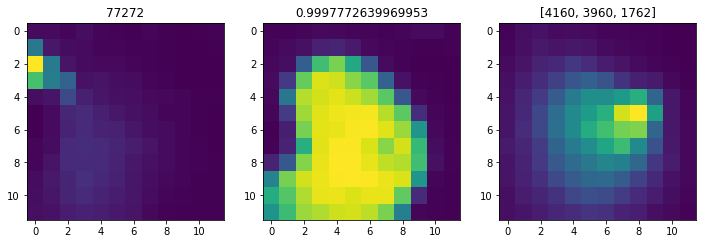

<Figure size 432x288 with 0 Axes>

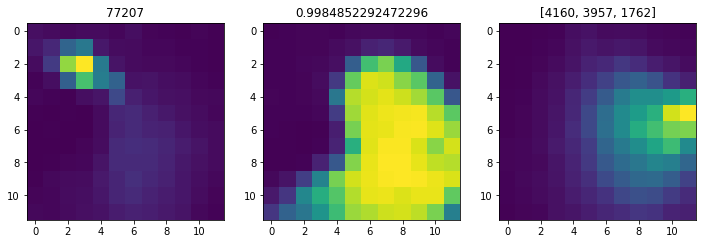

<Figure size 432x288 with 0 Axes>

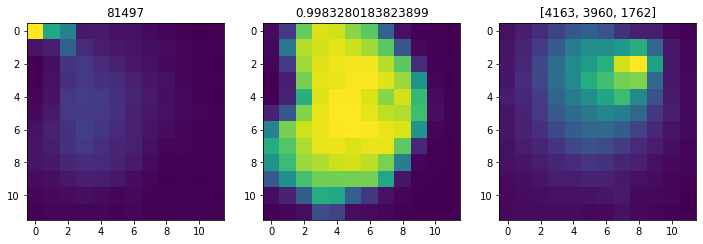

<Figure size 432x288 with 0 Axes>

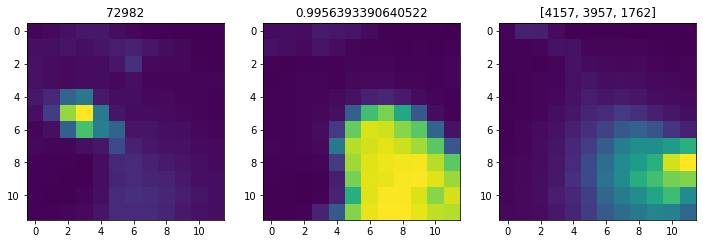

<Figure size 432x288 with 0 Axes>

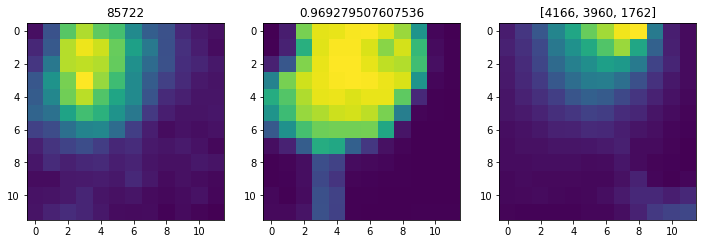

In [168]:
begin = 0; 
end = 5
for ii, subvol in enumerate(arr[begin:end]): 
    fig = plt.figure()
    f, axarr = plt.subplots(1,3, figsize=(12,12) )  
    axarr[0].imshow(subvol[2][:,:,3] )
    axarr[1].imshow(subvol[2][:,:,6] )
    axarr[2].imshow(subvol[2][:,:,9] )
    
    axarr[0].set_title( subvol[1] ) 
    axarr[1].set_title( subvol[0] ) 
    axarr[2].set_title( coords[subvol[1]] ) 
    

In [169]:
# uncomment next line to print coordinates of ground truth cells
# cells 

In [ ]:
# NEXT STEP IS TO FITLER OUT DUPLICATES

#[4162, 3959, 1762]),
#[4120, 3945, 1746]),
#[4126, 3977, 1784]), #idx = 31129, #score = 25th highest
#[4186, 4074, 1766]),
#[4269, 3964, 1771]),
#[4162, 3988, 1772]),
#[4199, 3920, 1756]),
#[4175, 3974, 1767]),
#[4116, 3970, 1755])]*

""" Results from stride=3: 
accuracy = 8/8 + ... unknown cells"""
# new = 
#     [4232, 4026, 1783]
#     [4166, 3957, 1762]
#     [4106, 4065, 1720]*
#     [4106, 3984, 1753]*
#     [4106, 3999, 1732]
#     [4145, 4029, 1777]